In [9]:
!pip install better_exceptions

In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import scipy
import scipy.io
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from torch.autograd import Variable
import torch, torch.nn as nn
import torch.nn.functional as F

import scipy
import sklearn
import sklearn.metrics
import sklearn.linear_model
import math

import numpy as np
import scipy
import scipy.signal
import random
import scipy
import math
import pandas as pd

import sklearn
import sklearn.linear_model

import colorednoise

In [2]:
import numpy as np
import scipy
import scipy.signal
import random
import scipy
import math

import colorednoise


def data_generator(X, Y, batch_size, lag_backward, lag_forward, shuffle = True, infinite = True):
    assert len(X)==len(Y) or len(Y)==0, f"{len(X)}!={len(Y)} and {len(Y)}==0"
    total_lag = lag_backward + lag_forward
    all_batches = math.ceil((X.shape[0] - total_lag)/batch_size)
    samples_in_last_batch = (X.shape[0] - total_lag) % batch_size
    batch = 0
    random_core = np.arange(lag_backward, X.shape[0]-lag_forward)
    while True:
        if shuffle: np.random.shuffle(random_core)
        for batch in range(all_batches):       
            batch_start = batch*batch_size
            batch_end = (batch+1)*batch_size
            if batch_end>=len(random_core): batch_end = None
            batch_samples = random_core[batch_start : batch_end]

            batch_x = np.array([X[i - lag_backward : i + lag_forward] for i in batch_samples])
            batch_x = np.swapaxes(batch_x,1,2)

            if len(Y) > 0:
                batch_y = Y[[batch_samples]] 
                yield (batch_x, batch_y)
            else:
                yield batch_x
        
        if not infinite:
            break

def generate_random_filters(number_of_filters, lower_frequency, upper_frequency, filters_broadband, frequency):
    filters_lower_bands = np.random.uniform(lower_frequency, upper_frequency, filters_broadband)
    filters_upper_bands = [min(lower_band + filters_broadband, int(frequency / 2)) for lower_band in filters_lower_bands]
    assert(len(filters_lower_bands) == len(filters_upper_bands))
    filters = []
    for filter_lower_band, filter_upper_band in zip(filters_lower_bands, filters_upper_bands):
        single_filter = scipy.signal.firwin(34, [filter_lower_band, filter_upper_band], fs=frequency, pass_zero=False)
    return filters


def filter_signals(signals, filters):
    number_of_signals = signals.shape[1]
    assert number_of_signals == len(filters)
    filtered_signals = np.copy(signals)
    for index, single_filter in enumerate(filters):
        if single_filter is None:
            filtered_signals[:, index] = signals[:, index]
            continue
        filtered_signals[:, index] = np.convolve(signals[:, index], single_filter, mode = "same")
    return filtered_signals


def envelope_signals(signals):
    enveloped_signals = np.zeros(signals.shape)
    for i in range(signals.shape[1]):
        enveloped_signals[:, i] = np.abs(scipy.signal.hilbert(signals[:, i]))
    return enveloped_signals


def mix_signals(signals, output_dimension):
    input_dimension = signals.shape[1]
    mixing_matrix = np.random.uniform(0, 1, (input_dimension, output_dimension))
    mixed_signals = np.matmul(signals, mixing_matrix)
    return mixed_signals

def get_spectrum(y, Fs):
    n = len(y) # length of the signal
    k = scipy.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = scipy.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    return abs(Y)

def plotSpectrum(y, Fs):

    n = len(y) # length of the signal
    k = scipy.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = scipy.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    
    plt.figure(figsize=(14, 1))
    plt.plot(frq,abs(Y)) # plotting the spectrum
    plt.show()



def make_lag(X, lag_backward, lag_forward):
    assert(lag_backward >= 0)
    assert(lag_forward >= 0)
    X_lag_list = []
    for i in reversed(range(1, lag_backward + 1)):
        X_lag_list.append(X[lag_backward - i:-lag_forward - i if lag_forward + i > 0 else None])
    X_lag_list.append(X[lag_backward:-lag_forward if lag_forward > 0 else None])
    for i in range(1, lag_forward + 1):
        X_lag_list.append(X[lag_backward + i:-lag_forward + i if lag_forward - i > 0 else None])
    return np.concatenate(X_lag_list, axis=1)

In [3]:
RANDOM_SEED = 67

FREQUENCY = 1000

signals_length = 2_000_000
sources_dimension = 4
noises_dimension = 40
sensors_dimension = 5
output_dimension = 4
target_lag = 5
BETA = 1

minor_noise = colorednoise.powerlaw_psd_gaussian(BETA, signals_length * sensors_dimension).reshape((signals_length, sensors_dimension))


np.random.seed(RANDOM_SEED)

signals = np.random.normal(0, 1, (signals_length, sources_dimension))
filters = [
    scipy.signal.firwin(100, [30, 80], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [80, 120], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [120, 170], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [170, 220], fs=FREQUENCY, pass_zero=False),
]
assert len(filters) == sources_dimension
filtered_signals = filter_signals(signals, filters)
enveloped_signals = envelope_signals(filtered_signals)
mixing_matrix = np.random.uniform(0, 1, (sources_dimension, sensors_dimension))
mixed_signals = np.matmul(filtered_signals, mixing_matrix)

weight_matrix = np.random.uniform(0, 1, (target_lag, sources_dimension))
target = scipy.signal.convolve2d(np.pad(enveloped_signals, pad_width=((2, 2), (0, 0)), mode="edge",), weight_matrix, mode='valid')

noisy_signals = colorednoise.powerlaw_psd_gaussian(BETA, signals_length * noises_dimension).reshape((signals_length, noises_dimension))
np.random.normal(0, 1, (signals_length, noises_dimension))
noisy_filters = [
    scipy.signal.firwin(100, [40, 70], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [90, 110], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [130, 160], fs=FREQUENCY, pass_zero=False),
    scipy.signal.firwin(100, [180, 210], fs=FREQUENCY, pass_zero=False),
] * 10

assert len(noisy_filters) == noises_dimension, f'{len(noisy_filters)} != {noises_dimension}'
filtered_noisy_signals = filter_signals(noisy_signals, noisy_filters)
noise_mixing_matrix = np.random.uniform(0, 1, (noises_dimension, sensors_dimension))
mixed_noises = np.matmul(filtered_noisy_signals, noise_mixing_matrix)

noisy_input = mixed_signals + 1 * mixed_noises  + 0.1 * minor_noise


X = noisy_input
Y = target

assert len(X) == len(Y), f"{len(X)} != {len(Y)}"
assert np.linalg.matrix_rank(X) == sensors_dimension

X_original = np.copy(X)
X_scaler = sklearn.preprocessing.StandardScaler()
Y_scaler = sklearn.preprocessing.StandardScaler()

X = X_scaler.fit_transform(X)
Y = Y_scaler.fit_transform(Y)

NTR = int(signals_length / 2)

train_slice = slice(None, NTR)
test_slice = slice(NTR, None)

X_train = X[train_slice, :]
Y_train = Y[train_slice, :]

X_test = X[test_slice, :]
Y_test = Y[test_slice, :]


def get_weights(X, Y, intercept=False):
    if intercept:
        X = np.concatenate([np.ones(X.shape[0]).reshape((-1, 1)), X], axis=1)
    return np.linalg.multi_dot([np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose(), Y])[int(intercept):]


def get_interpretable(X, W, Y):
    y_col = Y.shape[1]
    return np.linalg.multi_dot([
        np.cov(X, rowvar=False), 
        W, 
        np.linalg.inv(np.cov(Y, rowvar=False).reshape((y_col, y_col)))
    ])


def compare_weights(interpret):
    for i in range(sources_dimension):
        print(round(np.corrcoef(interpret[:, i], mixing_matrix[i, :], rowvar=False)[0, 1], 3), end="\t")
    print()


print("mixing_matrix:\n", mixing_matrix.transpose())

mixing_matrix:
 [[0.33384428 0.06322857 0.06471068 0.16772285]
 [0.18286733 0.18788121 0.16565825 0.55860323]
 [0.04175425 0.67152578 0.42231403 0.77706902]
 [0.08697226 0.94362509 0.01462183 0.53486307]
 [0.58261606 0.77526983 0.71845051 0.26313062]]


In [4]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class envelope_detector(nn.Module):
    def __init__(self, in_channels, channels_per_channel):
        super(self.__class__,self).__init__()
        self.FILTERING_SIZE = 100
        self.ENVELOPE_SIZE = 100
        self.CHANNELS_PER_CHANNEL = channels_per_channel
        self.OUTPUT_CHANNELS = self.CHANNELS_PER_CHANNEL * in_channels
        self.pre_envelope_batchnorm = torch.nn.BatchNorm1d(self.OUTPUT_CHANNELS, affine=False)
        self.conv_filtering = nn.Conv1d(in_channels, self.OUTPUT_CHANNELS, bias=False, kernel_size=self.FILTERING_SIZE, groups=in_channels)
        self.conv_envelope = nn.Conv1d(self.OUTPUT_CHANNELS, self.OUTPUT_CHANNELS, kernel_size=self.ENVELOPE_SIZE, groups=self.OUTPUT_CHANNELS)
        self.conv_out = None
        self.features = None

    def forward(self, x):
        x = self.conv_filtering(x)
        self.features = x.cpu().data.numpy()
        self.conv_out = x.cpu().data.numpy()
        x = self.pre_envelope_batchnorm(x)
        x = torch.abs(x)
        x = self.conv_envelope(x)
        return x


class simple_net(nn.Module):
    def __init__(self, in_channels, output_channels, lag_backward, lag_forward):
        super(self.__class__,self).__init__()
        self.ICA_CHANNELS = sources_dimension
        self.CHANNELS_PER_CHANNEL = 1

        self.middle_point_share = lag_backward * 1.0 / (lag_backward + lag_forward)

        self.ica = nn.Conv1d(in_channels, self.ICA_CHANNELS, 1)
        
        self.total_input_channels = self.ICA_CHANNELS
        self.detector = envelope_detector(self.total_input_channels, self.CHANNELS_PER_CHANNEL)

        self.final_out_features = sources_dimension * target_lag
        self.wights_second = nn.Linear(self.final_out_features, output_channels)
        self.fuck_channels = None
        self.envelopes = None
        

    def forward(self, x):
        x = self.ica(x)
        self.fuck_channels = x.cpu().data.numpy()
        x = self.detector(x)
        middle_point = int((x.shape[-1]) * self.middle_point_share)
        self.envelopes = x[:, :, middle_point].contiguous().cpu().data.numpy()
        x = x[:, :, middle_point - int(target_lag /2):middle_point + int(target_lag /2)+1].contiguous()
        #self.features = x.cpu().detach().numpy()
        x = x.view(x.size(0), -1)
        x = self.wights_second(x)
        return x


In [5]:
IS_UNMIXED_GET = False

batch_size = 500
lag_backward = 120
lag_forward = 120

model = simple_net(X_train.shape[1], Y_test.shape[1], lag_backward, lag_forward)


print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)


Trainable params:  849
Total params:  849


In [24]:

# optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_history = []
pbar = tqdm_notebook()
for x_batch, y_batch in data_generator(X_train, Y_train, batch_size, lag_backward, lag_forward):
    model.train()
    assert x_batch.shape[0]==y_batch.shape[0]
    x_batch = Variable(torch.FloatTensor(x_batch))
    y_batch = Variable(torch.FloatTensor(y_batch))
    optimizer.zero_grad()
    y_predicted = model(x_batch)
    loss = loss_function(y_predicted, y_batch)

    loss.backward()
    optimizer.step()
    loss_history.append(loss.cpu().data.numpy())    
    pbar.update(1)
    eval_lag = min(100,len(loss_history))
    pbar.set_postfix(loss = np.mean(loss_history[-eval_lag:]))
    
    if len(loss_history) == 2000:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

    if len(loss_history) == 5000:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)
        
    if len(loss_history) == 7000:
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    
    if len(loss_history) % 1000 == 0:
        Y_sliced = Y_test[lag_backward:-lag_forward if lag_forward > 0 else None]
        Y_predicted = []
        for x_batch, y_batch in data_generator(X_test, Y_test, batch_size, lag_backward, lag_forward, shuffle=False, infinite= False):
            model.eval()
            assert x_batch.shape[0]==y_batch.shape[0]
            x_batch = Variable(torch.FloatTensor(x_batch))
            y_batch = Variable(torch.FloatTensor(y_batch))
            y_predicted = model(x_batch).cpu().data.numpy()
            Y_predicted.append(y_predicted)

        Y_predicted = np.concatenate(Y_predicted, axis = 0)
        print("Correlation   test ###")
        for i in range(Y_predicted.shape[1]):
            print(round(np.corrcoef(Y_predicted[:, i], Y_sliced[:, i], rowvar=False)[0,1], 4), end="\t")
            
        print("\n#############")


/tmp/ipykernel_41798/3889594549.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook()


0it [00:00, ?it/s]

/tmp/ipykernel_41798/3702784876.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  batch_y = Y[[batch_samples]]


Correlation   test ###
0.7717	
#############
Correlation   test ###
0.7721	
#############
Correlation   test ###
0.7723	
#############
Correlation   test ###
0.772	
#############
Correlation   test ###
0.7723	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7722	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7727	
#############
Correlation   test ###
0.7726	
#############
Correlation   test ###
0.7727	
#############
Correlation

KeyboardInterrupt: 

/tmp/ipykernel_41798/2322764558.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_batch, y_batch in tqdm_notebook(data_generator(X_test, Y_test, batch_size, lag_backward, lag_forward, shuffle=False, infinite= False)):


0it [00:00, ?it/s]

/tmp/ipykernel_41798/3702784876.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  batch_y = Y[[batch_samples]]


Correlation   test ###
0.77	

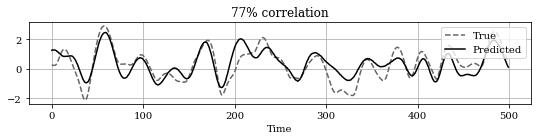

In [25]:
Y_sliced = Y_test[lag_backward:-lag_forward if lag_forward > 0 else None]
enveloped_signals_sliced = enveloped_signals[test_slice, :][lag_backward:-lag_forward if lag_forward > 0 else None]
Y_predicted = []
envelopes = []
for x_batch, y_batch in tqdm_notebook(data_generator(X_test, Y_test, batch_size, lag_backward, lag_forward, shuffle=False, infinite= False)):
    model.eval()
    assert x_batch.shape[0]==y_batch.shape[0]
    x_batch = Variable(torch.FloatTensor(x_batch))
    y_batch = Variable(torch.FloatTensor(y_batch))
    y_predicted = model(x_batch).cpu().data.numpy()
    Y_predicted.append(y_predicted)
    envelopes.append(model.envelopes)

envelopes = np.concatenate(envelopes, axis = 0)
Y_predicted = np.concatenate(Y_predicted, axis = 0)
print("Correlation   test ###")
for i in range(Y_predicted.shape[1]):
    print(round(np.corrcoef(Y_predicted[:, i], Y_sliced[:, i], rowvar=False)[0,1], 2), end="\t")

ZOOM = 500
for i in range(Y_predicted.shape[1]):
    plt.figure(figsize=(9, 1.5))
    plt.rc('font', family='serif')
    corr = np.corrcoef(Y_predicted[:, i], Y_sliced[:, i], rowvar=False)[0,1]
    plt.title(str(int(corr * 100)) + "% correlation")
    plt.plot(Y_sliced[:ZOOM, i], label = 'True',  color='0.40', ls="--")
    plt.plot(Y_predicted[:ZOOM, i], color='k', label = 'Predicted')
    plt.legend(loc="upper right")
    plt.xlabel("Time")
    plt.grid()
    plt.show()

#fig.savefig(fname='target_not_perfect' + ".pdf", format="pdf", bbox_inches = "tight")

In [26]:
X_unmixed = []
for x_batch in tqdm_notebook(data_generator(X_train, [], batch_size, lag_backward, lag_forward, shuffle=False, infinite= False)):
    #### Train
    model.eval()
    x_batch = Variable(torch.FloatTensor(x_batch))
    y_predicted = model(x_batch).cpu().data.numpy()
    X_unmixed.append(model.fuck_channels)

X_unmixed1 = np.concatenate(X_unmixed, axis = 0)[:, :, -1]

IS_UNMIXED_GET = True

/tmp/ipykernel_41798/1588754606.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_batch in tqdm_notebook(data_generator(X_train, [], batch_size, lag_backward, lag_forward, shuffle=False, infinite= False)):


0it [00:00, ?it/s]

In [27]:
np.concatenate(X_unmixed, axis=0).shape

(999760, 4, 240)

In [28]:
X_train_full = []
for index, x_batch in tqdm_notebook(enumerate(data_generator(X_train, [], batch_size, lag_backward, lag_forward, shuffle=False, infinite= False))):
    #### Train
    if index % 50 == 0:
        X_train_full.append(x_batch)

X_train_full = np.concatenate(X_train_full, axis = 0)


/tmp/ipykernel_41798/3260398485.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, x_batch in tqdm_notebook(enumerate(data_generator(X_train, [], batch_size, lag_backward, lag_forward, shuffle=False, infinite= False))):


0it [00:00, ?it/s]

In [29]:
import sklearn.preprocessing as skp
import scipy.signal as scs
from itertools import product

In [30]:
WEIGHTS_COLOR = "k"
PATTENS_COLOR = "#1f77b4"
TRUE_COLOR = "#ff7f0e"
PATTERNS_NAIVE_COLOR = "#d62728"

WEIGHTS_MARKER = "."
PATTENS_MARKER = "v"
TRUE_MARKER = "o"
PATTERNS_NAIVE_MARKER = "P"


4
(4, 1, 100)
unmixed_ch_id=0
unmixed_ch_id=1
unmixed_ch_id=2
unmixed_ch_id=3
Patters performance
-0.974	0.851	0.945	0.981	
Ossadtchi Patters performance
-0.985	1.0	0.959	0.999	


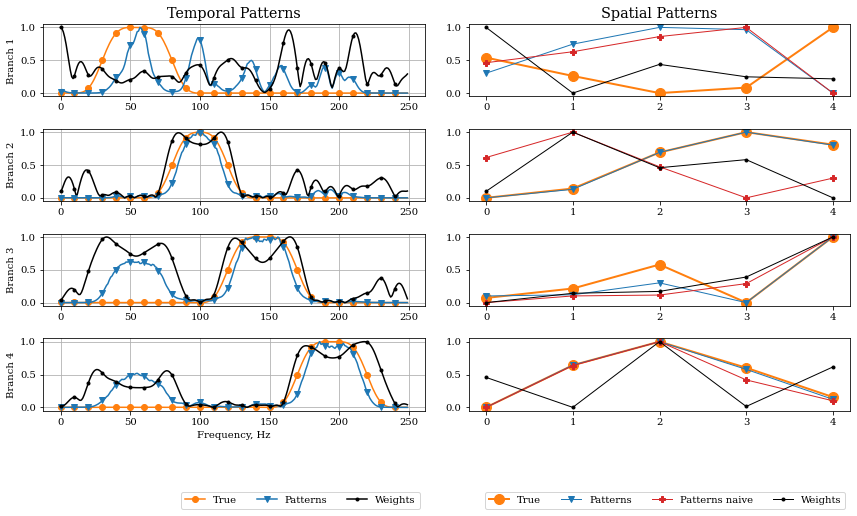

In [31]:
assert(IS_UNMIXED_GET)

X_unmixed = np.copy(X_unmixed1)

KOSTYL_CHOOSE = [3, 1, 2, 0]
KOSTYL_CHOOSE_BOOL = True

NPERSEQ = 1000

COMPARISON_TOLERANCE = 1e-10
ZOOM = 250

def get_freq_domain(signal, frequency):
    n = NPERSEQ
    ampletude = np.abs(np.fft.fft(signal,n))
    frequencies = np.fft.fftfreq(n , 1 / frequency)
    assert len(ampletude) == len(frequencies), f"{len(ampletude)}!={len(frequencies)}"
    end = len(frequencies) // 2
    return frequencies[:end], ampletude[:end]

Y_sliced = Y_train[lag_backward:-lag_forward if lag_forward > 0 else None]

unmixed_ch_cnt = X_unmixed.shape[1]
print(unmixed_ch_cnt)
convs_weights = list(model.detector.conv_filtering.cpu().parameters())[0].detach().numpy()
print(convs_weights.shape)
ica_weights = model.ica.weight.cpu().detach().numpy()[:, :, 0].T
ica_weights_scaled = ica_weights / np.sqrt(X_scaler.var_.reshape(-1, 1))

if KOSTYL_CHOOSE_BOOL:
    # learned patterns can be permutated. here we manually need to fix it
    convs_weights = convs_weights[KOSTYL_CHOOSE,:,:]
    ica_weights = ica_weights[:,KOSTYL_CHOOSE]
    ica_weights_scaled = ica_weights_scaled[:,KOSTYL_CHOOSE]
    X_unmixed = X_unmixed[:, KOSTYL_CHOOSE]
    
assert convs_weights.shape[0] % unmixed_ch_cnt == 0
filters_per_ch = convs_weights.shape[0] // unmixed_ch_cnt

anal_data = []
for i_u, i_f in product(range(unmixed_ch_cnt), range(filters_per_ch)):
    anal_data.append((i_u, convs_weights[i_u * filters_per_ch + i_f, 0, :]))

FINAL_FUGURE, FINAL_AXIS = plt.subplots(4, 2)
FINAL_FUGURE.set_figwidth(12)
FINAL_FUGURE.set_figheight(6)
plt.rc('font', family='serif', size=12)
FINAL_FUGURE.tight_layout()
for i in range(4):
    plt.setp(FINAL_AXIS[i, 0], ylabel=f"Branch {i + 1}")    
plt.setp(FINAL_AXIS[3, 0], xlabel='Frequency, Hz')
FINAL_AXIS[0, 0].set_title('Temporal Patterns')
FINAL_AXIS[0, 1].set_title('Spatial Patterns')
plt.rc('font', family='serif', size=10)
params = [
        dict(label = 'True', linewidth=1.5, marker=TRUE_MARKER, color=TRUE_COLOR, markevery=10),
        dict(label = 'Patterns', linewidth=1.5, marker=PATTENS_MARKER, color=PATTENS_COLOR, markevery=10),
        dict(label = 'Weights', linewidth=1.5, marker=WEIGHTS_MARKER, color=WEIGHTS_COLOR, markevery=10),
    ]
for i, (unmixed_ch_id, weights) in enumerate(anal_data):
    frequencies, spectrum_input = scs.welch(X_unmixed[:, unmixed_ch_id], FREQUENCY, nperseg=NPERSEQ, detrend='linear')
    spectrum_input = skp.minmax_scale(spectrum_input[:-1])
    
    _, ampletude = get_freq_domain(weights, FREQUENCY)
    frequencies_true, ampletude_true = get_freq_domain(filters[unmixed_ch_id], FREQUENCY)
    print(f"{unmixed_ch_id=}")

    ampletude = skp.minmax_scale(ampletude)
    ampletude_true = skp.minmax_scale(ampletude_true)
    recovered = skp.minmax_scale(ampletude * skp.minmax_scale(spectrum_input))
    
    for y, p in zip((ampletude_true, recovered, ampletude), params):
        FINAL_AXIS[i, 0].plot(frequencies[:ZOOM], y[:ZOOM], **p)     
    
    FINAL_AXIS[i, 0].grid()
FINAL_AXIS[0, 0].legend(bbox_to_anchor=(1, -5.4), ncol=4)


def get_ossagtchi_spatial_patterns(X, temproral_weights, spatial_weights):
    patterns = np.zeros_like(spatial_weights)
    X_filtered = np.zeros_like(X)
    for i_comp in range(temproral_weights.shape[0]):
        for i_ch in range(X.shape[1]):
            X_filtered[:, i_ch] = np.convolve(X[:, i_ch], temproral_weights[i_comp, :], mode="same")
        patterns[:, i_comp] = np.cov(X_filtered.T) @ spatial_weights[:, i_comp]
    return patterns

interpret = np.cov(X_original.T) @ ica_weights_scaled
interpret_ossadtchi = get_ossagtchi_spatial_patterns(X_original, np.squeeze(convs_weights), ica_weights_scaled)

print("Patters performance")
compare_weights(interpret)
print("Ossadtchi Patters performance")
compare_weights(interpret_ossadtchi)

METODS = ["True", "Patterns", "Patterns naive", "Weights"]
LS = [TRUE_MARKER, PATTENS_MARKER, PATTERNS_NAIVE_MARKER, WEIGHTS_MARKER]
LC = [TRUE_COLOR, PATTENS_COLOR, PATTERNS_NAIVE_COLOR, WEIGHTS_COLOR]
plt.rc('font', family='serif', size=12)
for i in range(0, sources_dimension):
    matrix = np.array([
        mixing_matrix.T[:, i],
        interpret_ossadtchi[:, i],
        interpret[:, i],
        ica_weights[:, i],
    ])
    lines = sklearn.preprocessing.minmax_scale(np.abs(matrix), axis=1)
    for line, label, line_style, line_color in list(zip(lines, METODS, LS, LC)):
        if label == "Joint":
            continue
        FINAL_AXIS[i, 1].plot(line, label=label, linewidth=1 if label != "True" else 2, marker=line_style, color=line_color, markevery=1, markersize=None if label != "True" else 10)
        FINAL_AXIS[i, 1].set_xticks(range(5))
plt.rc('font', family='serif', size=10)
FINAL_AXIS[0, 1].legend(bbox_to_anchor=(1, -5.4), ncol=4)

In [16]:
X_unmixed1.shape

(999760, 4)

In [41]:
convs_weights.shape

(4, 1, 100)

In [42]:
ica_weights_scaled.shape

(5, 4)

In [43]:
interpret_ossadtchi.shape

(5, 4)